In [1]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from scipy.optimize import minimize
import networkx as nx
from scipy import sparse

In [122]:
def repetition_code(n):
    # generates the parity check matrix for a repitition code with parameters [n, 1, n]

    H = np.zeros((n-1, n), dtype=int)
    for i in range(n-1):
        H[i][i] = 1
        H[i][i+1] = 1

    return H

H = repetition_code(15)

# configuration model
# https://en.wikipedia.org/wiki/Configuration_model

# n = 6
# deg_v = 2 # w_c. Every bit is in this many checks
# deg_c = 3 # w_r. Every check has this many bits in it
# num_checks = (n*deg_v)//deg_c
# k = n - num_checks

# vs = np.array([[j for i in range(deg_v)] for j in range(n)]).flatten()
# cs = np.array([[j for i in range(deg_c)] for j in range(num_checks)]).flatten()

# H = np.zeros((num_checks, n), dtype=bool)

# while (vs.size and cs.size):
#     # choose random 'stub' from each array
#     double_edge = True
#     while(double_edge):
#         v_ind = np.random.randint(0, len(vs))
#         c_ind = np.random.randint(0, len(cs))

#         if (H[cs[c_ind]][vs[v_ind]] != 1):
#             double_edge = False
#             H[cs[c_ind]][vs[v_ind]] = 1
#             vs = np.delete(vs, v_ind)
#             cs =np.delete(cs, c_ind)

# H = sparse.csc_matrix(H)

hx1 = sparse.kron(H, np.eye(H.shape[1], dtype=bool))
hx2 = sparse.kron(np.eye(H.shape[0], dtype=bool), H.T)
Hx = sparse.csr_matrix(sparse.hstack([hx1, hx2]))

hz1 = sparse.kron(np.eye(H.shape[1], dtype=bool), H)
hz2 = sparse.kron(H.T, np.eye(H.shape[0], dtype=bool))
Hz = sparse.csr_matrix(sparse.hstack([hz1, hz2]))

H = sparse.csr_matrix(sparse.vstack([Hx, Hz]))
# print(H.toarray())

n = H.shape[1]
m = H.shape[0]
m1 = Hx.shape[0]
m2 = Hz.shape[0]

G = nx.Graph()
G.add_nodes_from(np.arange(n+m))

for i in range(n):
    G.nodes[i]['type'] = 'k'
for i in range(m1):
    G.nodes[i+n]['type'] = 'r'
    # x gen
    for j in range(n):
        if Hx.toarray()[i][j]: G.add_edge(i+n, j)

for i in range(m2):
    G.nodes[i+m1+n]['type'] = 'b'
    #z gen
    for j in range(n):
        if Hz.toarray()[i][j]: G.add_edge(i+m1+n, j)
n = n+m

# connectivity graph

# G = nx.Graph()
# for i in np.arange(n):
#     G.add_node(i)
#     G.nodes[i]['type'] = 'k'

# for i in range(m):
#     checks = H[i].indices
#     for pair in itertools.combinations(checks, 2):
#         G.add_edge(pair[0], pair[1])
# len(G.edges)

In [123]:
def print_graph(G, edges=False):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    lines = []
    xs = []
    ys = []
    cs = []
    
    for i in range(G.number_of_nodes()):
        v = G.nodes[i]
        xs.append(v['x'])
        ys.append(v['y'])
        cs.append(v['type'])
        for nbr in G.neighbors(i):
            lines.append([(v['x'], v['y']), (G.nodes[nbr]['x'], G.nodes[nbr]['y'])])

    # pts = itertools.product(np.arange(max(xs)+1), np.arange(max(ys)+1))
    pts = itertools.product(np.arange(int(5*np.sqrt(n))), np.arange(int(5*np.sqrt(n))))

    plt.scatter(*zip(*pts), s=3, c='k')
    plt.scatter(xs, ys, s=20, c=cs)

    if (edges):
        lc = mc.LineCollection(lines, colors='k', linewidth=1)
        ax.add_collection(lc)
    # ax.axis('off')
    plt.show()

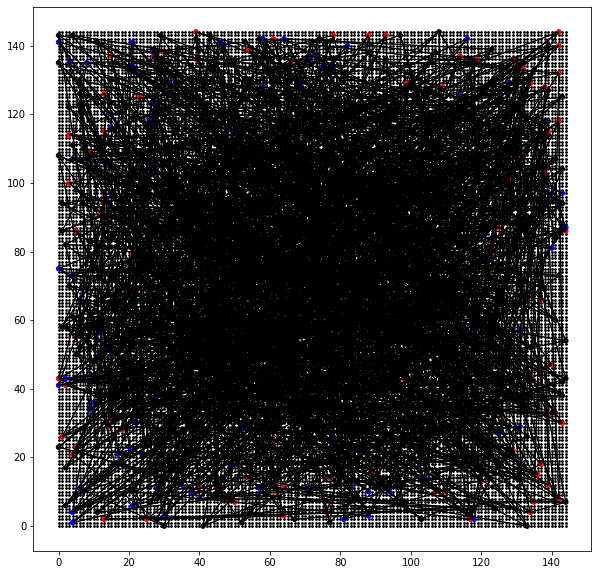

In [124]:
pos = np.array([[{'x':i,'y':j} for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))]).flatten()
grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

initial_pos = random.sample(list(pos), n)
for i in range(n):
    pt = (initial_pos[i]['x'], initial_pos[i]['y'])
    G.nodes[i]['x'] = pt[0]
    G.nodes[i]['y'] = pt[1]
    grid[pt[0]][pt[1]] = i+1

print_graph(G, edges=True)

In [98]:
def find_nearest_available(x, y):
    n = len(grid[0])
    visited = np.zeros((n,n))

    queue = [(x, y)]
    for _ in range(n**2):
        x, y = queue.pop(0)
        
        if (not grid[x][y]):
            return (x, y)
        
        pot_nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
        for nbr in pot_nbrs:
            new_x, new_y = nbr
            if ((0 <= new_x < n) and (0 <= new_y < n)):
                if (not visited[new_x][new_y]):
                    queue.append(nbr)
                    visited[new_x][new_y] = True


def points_with_manhattan_distance(p, d):
    n = len(grid[0])
    result = []
    for i in range(-d, d+1):
        for j in range(-d, d+1):
            new_x, new_y = (p[0]+i, p[1]+j)
            if ((manhattan(p, (new_x, new_y)) <= d)
                and (0 <= new_x < n) and (0 <= new_y < n) and (not grid[new_x][new_y])):
                result.append((new_x, new_y))
    return result


# def swap_nodes(p):
#     print(p)
#     n = len(grid[0])
#     x, y = p
#     v1 = grid[x][y]
#     pot_nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
#     for nbr in pot_nbrs:
#         new_x, new_y = nbr
#         if ((0 <= new_x < n) and (0 <= new_y < n) and (grid[new_x][new_y])):
#             v2 = grid[new_x][new_y]

#             if (v1.tot_edge_len(p) + v2.tot_edge_len(nbr) > v1.tot_edge_len(nbr) + v2.tot_edge_len(p)):
#                 v1.x = new_x
#                 v1.y = new_y
#                 v2.x = x
#                 v2.y = y
#                 grid[x][y] = v2
#                 grid[new_x][new_y] = v1



def compact(dir, gamma):
    def S(dir):
        edges = []
        for i in range(len(grid[0])):
            if (dir): # horizontal
                nodes = np.where(grid[:,i])[0]
                for j in range(len(nodes)-1):
                    edges.append((grid[nodes[j]][i]-1, grid[nodes[j+1]][i]-1))
            else: # vertical
                nodes = np.where(grid[i])[0]
                for j in range(len(nodes)-1):
                    edges.append((grid[i][nodes[j]]-1, grid[i][nodes[j+1]]-1))
        return edges
    
    def fun(x):
        # x is a list of x (y) coordinates of the nodes
        return sum([(x[edge[0]] - x[edge[1]])**2 for edge in G.edges()]) #maybe abs value
    
    x = [v[1]['x'] for v in G.nodes(data=True)] if dir else [v[1]['y'] for v in G.nodes(data=True)]
    vis_edges = S(dir)

    res = minimize(fun, x0=x, method="SLSQP", 
                   constraints=[{'type': 'ineq', 'fun': lambda x, e=e: x[e[1]] - x[e[0]] - gamma} for e in vis_edges],
                   bounds=[(0, len(grid[0])-1) for _ in range(len(x))])

    for i, p in enumerate((res.x).astype(int)):
        v = G.nodes[i]
        if (dir):
            v['x'] = p
        else:
            v['y'] = p

def manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def tot_edge_len(v, p):
    return sum([manhattan(p, (G.nodes[nbr]['x'], G.nodes[nbr]['y'])) for nbr in G.neighbors(v)])

In [139]:
j = 0

%timeit np.median([G.nodes[v]['x'] for v in G.neighbors(j)])
# nbrMedY = np.median([G.nodes[v]['y'] for v in G.neighbors(j)])
# %timeit v = G.nodes[j]
%timeit x = int(min(max(nbrMedX + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
x, y = (5, 5)
%timeit new_x, new_y = find_nearest_available(x, y)
%timeit d = manhattan((x,y), (new_x, new_y))
%timeit pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)
pot_loc = (5, 5)
%timeit tmp_dist = tot_edge_len(j, (pot_loc[0], pot_loc[1]))

54.1 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.01 µs ± 903 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
11.9 µs ± 510 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
591 ns ± 38.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
13.4 µs ± 3.14 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.86 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [140]:
iters = int(90*np.sqrt(n))
T = int(2*np.sqrt(n))
k = (0.2/T)**(1/iters)
compactDir = True

for i in range(iters//2):
    print(i)
    for j in range(G.number_of_nodes()):
        # print(sum([manhattan((G.nodes[edge[0]]['x'], G.nodes[edge[0]]['y']), 
        #                      (G.nodes[edge[1]]['x'], G.nodes[edge[1]]['y'])) for edge in G.edges()]), 
        #                      np.count_nonzero(grid))
        nbrMedX = np.median([G.nodes[v]['x'] for v in G.neighbors(j)])
        nbrMedY = np.median([G.nodes[v]['y'] for v in G.neighbors(j)])

        v = G.nodes[j]
        x = int(min(max(nbrMedX + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
        y = int(min(max(nbrMedY + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))

        new_x, new_y = find_nearest_available(x, y)
        d = manhattan((x,y), (new_x, new_y))
        pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)

        dist = np.inf
        for pot_loc in pot_locs:
            tmp_dist = tot_edge_len(j, (pot_loc[0], pot_loc[1]))
            if (tmp_dist < dist):
                dist = tmp_dist
                new_x, new_y = pot_loc

        if ((v['x'], v['y']) == (new_x, new_y)):
            print("should swap")
        if (tot_edge_len(j, (new_x, new_y)) < tot_edge_len(j, (v['x'], v['y']))):
            grid[v['x']][v['y']] = 0
            v['x'] = new_x
            v['y'] = new_y
            grid[new_x][new_y] = j+1

    # if (i % 9 == 0):
    #     compact(compactDir, 3)
    #     compactDir = not compactDir

    #     grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

    #     for j in range(G.number_of_nodes()):
    #         grid[G.nodes[j]['x']][G.nodes[j]['y']] = j+1

    T *= k

# compact(True, 3)
# compact(False, 3)

for i in range(iters//2+1):
    for j in range(G.number_of_nodes()):
        # print(sum([manhattan((G.nodes[edge[0]]['x'], G.nodes[edge[0]]['y']), 
        #                      (G.nodes[edge[1]]['x'], G.nodes[edge[1]]['y'])) for edge in G.edges()]), 
        #                      np.count_nonzero(grid))
        nbrMedX = np.median([G.nodes[v]['x'] for v in G.neighbors(j)])
        nbrMedY = np.median([G.nodes[v]['y'] for v in G.neighbors(j)])

        v = G.nodes[j]
        x = int(min(max(nbrMedX + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
        y = int(min(max(nbrMedY + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))

        new_x, new_y = find_nearest_available(x, y)
        d = manhattan((x,y), (new_x, new_y))
        pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)

        dist = np.inf
        for pot_loc in pot_locs:
            tmp_dist = tot_edge_len(j, (pot_loc[0], pot_loc[1]))
            if (tmp_dist < dist):
                dist = tmp_dist
                new_x, new_y = pot_loc

        if ((v['x'], v['y']) == (new_x, new_y)):
            print("should swap2")
        if (tot_edge_len(j, (new_x, new_y)) < tot_edge_len(j, (v['x'], v['y']))):
            grid[v['x']][v['y']] = 0
            v['x'] = new_x
            v['y'] = new_y
            grid[new_x][new_y] = j+1

    # if (i % 9 == 0):
        
    #     # print_graph(n,gg)
    #     compact(compactDir, max(1, 1+(2*(iters//2-i-30)/(0.5*iters))))
    #     compactDir = not compactDir

    #     grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

    #     for j in range(G.number_of_nodes()):
    #         grid[G.nodes[j]['x']][G.nodes[j]['y']] = j+1

    T *= k

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

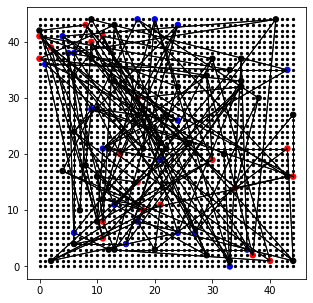

In [108]:
# compact(True, 1)
# compact(False, 1)
print_graph(G, edges=True)

In [125]:
edge_matrix = np.zeros((G.number_of_edges(), G.number_of_nodes()))
for i, e in enumerate(G.edges()):
    edge_matrix[i][e[0]] = 1
    edge_matrix[i][e[1]] = -1


P = edge_matrix.T @ edge_matrix

In [126]:
def S(dir):
    edges = []
    for i in range(len(grid[0])):
        if (dir): # horizontal
            nodes = np.where(grid[:,i])[0]
            for j in range(len(nodes)-1):
                edges.append((grid[nodes[j]][i]-1, grid[nodes[j+1]][i]-1))
        else: # vertical
            nodes = np.where(grid[i])[0]
            for j in range(len(nodes)-1):
                edges.append((grid[i][nodes[j]]-1, grid[i][nodes[j+1]]-1))
    return edges

vis = S(False)
# print(vis[0:4])
vis

[(356, 694),
 (694, 558),
 (558, 668),
 (668, 19),
 (19, 234),
 (234, 693),
 (693, 386),
 (477, 232),
 (232, 417),
 (417, 315),
 (145, 37),
 (37, 522),
 (522, 815),
 (815, 355),
 (355, 69),
 (310, 624),
 (624, 583),
 (583, 1),
 (1, 839),
 (829, 673),
 (673, 539),
 (539, 263),
 (263, 710),
 (710, 35),
 (35, 235),
 (235, 194),
 (124, 324),
 (324, 44),
 (44, 481),
 (481, 266),
 (266, 605),
 (605, 448),
 (448, 98),
 (98, 783),
 (756, 185),
 (185, 148),
 (148, 586),
 (586, 687),
 (687, 130),
 (130, 143),
 (143, 362),
 (362, 196),
 (656, 14),
 (14, 236),
 (383, 641),
 (669, 644),
 (644, 728),
 (728, 576),
 (576, 32),
 (32, 500),
 (635, 253),
 (253, 790),
 (790, 186),
 (106, 379),
 (379, 53),
 (53, 741),
 (741, 368),
 (190, 449),
 (449, 510),
 (476, 24),
 (24, 339),
 (339, 426),
 (426, 137),
 (137, 451),
 (451, 587),
 (587, 793),
 (793, 460),
 (460, 549),
 (613, 457),
 (457, 39),
 (440, 765),
 (765, 264),
 (264, 757),
 (757, 81),
 (81, 393),
 (393, 832),
 (832, 735),
 (735, 738),
 (738, 153),

In [127]:
gamma = 3
A1 = np.zeros((len(vis), G.number_of_nodes()))
l1 = np.full(len(vis), gamma)

for i, e in enumerate(vis):
    A1[i][e[1]] = 1
    A1[i][e[0]] = -1

A2 = np.eye(G.number_of_nodes())
l2 = np.zeros(G.number_of_nodes())

A = np.vstack([A1, A2])
l = np.concatenate([l1, l2])
u = np.full(len(vis) + G.number_of_nodes(), len(grid[0])-1)

In [128]:
import osqp
import numpy as np
from scipy import sparse

# Define problem data
P = sparse.csc_matrix(P)
q = np.zeros(G.number_of_nodes())
A = sparse.csc_matrix(A)
l = l
u = u

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace and change alpha parameter
prob.setup(P, q, A, l, u, alpha=1.0)

# Solve problem
res = prob.solve()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 841, constraints m = 1537
          nnz(P) + nnz(A) = 4698
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.00, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.00e+00   1.20e+00   1.00e-01   1.75e-02s
 200   6.1777e+04   3.60e-01   8.63e-02   6.35e-01   1.48e-01s
 325   6.1411e+04   3.76e-02   1.39e-02   6

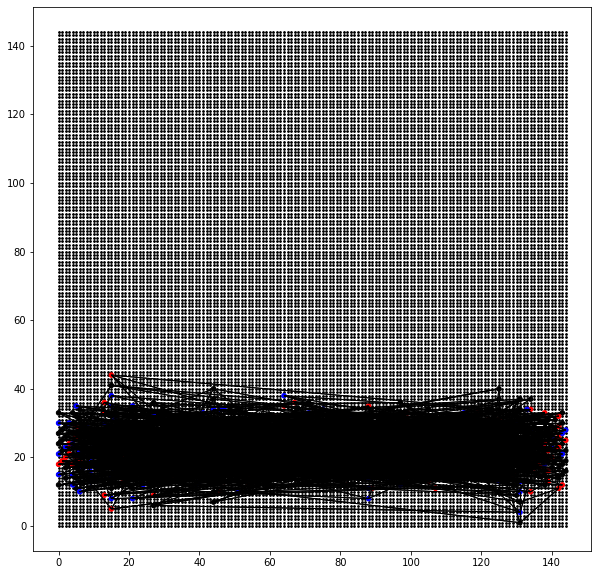

In [129]:
for i, p in enumerate((res.x).astype(int)):
    G.nodes[i]['y'] = p

print_graph(G, edges=True)

In [130]:
compact(True, 3)

KeyboardInterrupt: 